# Numbers Summation (using RNN LSTM)

> - <font size="+1">🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**</font><br/><br/>
> - ▶️ <font size="+1">**Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)</font>

## Experiment overview

In this experiment we will use [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to sum up two numbers (each number is in a range of `[1, 99]`). The summation expression (i.e. `"1+45"` or `37+68`) that will be sent to the RNN _input_ will be treated as a **string** (sequence of characters) and the _output_ of the RNN will also be a string (i.e. `"46"` or `"106"`) - the sequence of characters that will represent the result of summation. This is a "sequence-to-sequence" version of RNN implementation. We will use LSTM ([Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)) recurent neural network for this task.

For this experiment we will use [Tensorflow v2](https://www.tensorflow.org/) with its [Keras API](https://www.tensorflow.org/guide/keras).

![numbers_summation_rnn.png](../../demos/src/images/numbers_summation_rnn.png)

Inspired by [Learn to Add Numbers with an Encoder-Decoder LSTM Recurrent Neural Network](https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) article.

## Import dependencies

In [ ]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Generate a dataset

In order to train a neural network we need to generate a training dataset which will consist of examples `x` (set of summation expressions) and labels `y` (set of correct answers for each expression). We will start with generating a set of _numbers_ (not strings so far) and than we will convert the sets of numbers into _strings_.

In [4]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [5]:
# Generates summation sequences and summation results in form of vector if numbers.
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [6]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[13, 8], [85, 91], [12, 22]]

y_train:
 [21, 176, 34]


Recurrent neural networks are normally deals with the sequences (of one or many elements) on the input. In order to treat a summation expression as a sequence we will convert array of numbers (i.e. `[[13, 8], [85, 91], ...]`) into strings (i.e. `['13+8   ', '85+91  ', ...]`). We also want to add a space `" "` paddings to each string to make them all of the same length. After doing that we will be able to feed our RNN character by character (i.e. `1`, then `3`, then `+`, then `8`, then ` ` and so on).

In [7]:
# Convert array of numbers for x and y into strings.
# Also it adds a space (" ") padding to strings to make them of the same length. 
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [8]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['13+8   ' '85+91  ' '12+22  ']

y_train_str:
 ['21 ' '176' '34 ']


In [9]:
# Since we allow only numbers, plus sign and spaces the vocabulary looks pretty simple.
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [10]:
# Python dictionary that will convert a character to its index in the vocabulary.
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


Our RNN need to have a digits as an input to operate with (and not a strings). To convert summation expressions strings into number the first step we will do is to convert each character of each string into the position index of this character in the `vocabulary`.

In [11]:
# Converts x and y arrays of strings into array of char indices.
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [12]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 1  3 10  8 11 11 11]
 [ 8  5 10  9  1 11 11]
 [ 1  2 10  2  2 11 11]]

y_train_encoded:
 [[ 2  1 11]
 [ 1  7  6]
 [ 3  4 11]]


To make our dataset even more understandable for our recurrent neural network we will convert each number into `0/1` [one-hot vector](https://en.wikipedia.org/wiki/One-hot) (i.e. number `1` will be transformed into array `[0 1 0 0 0 0 0 0 0 0 0 0]`).

In [13]:
# Convert x and y sets of numbers into one-hot vectors.
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [14]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


Now we may combine all the function together and create a one function that will do all the work to generate a dataset in the proper format for us.

In [15]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [16]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 0 0 0 0 0 1 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


In [17]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [19]:
# How many characters each summation expression has.
input_sequence_length = x.shape[1]

# How many characters the output sequence of the RNN has.
output_sequence_length = y.shape[1]

# The length of one-hot vector for each character in the input (should be the same as vocabulary_size).
supported_symbols_num = x.shape[2]

# The number of different characters our RNN network could work with (i.e. it understands only digits, "+" and " ").
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [21]:
# Converts a sequence (array) of one-hot encoded vectors back into the string based on the provided vocabulary.
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [23]:
decode(y[0], vocabulary)

'61 '

## Build a model

We will use a [Sequential] TensorFlow model with [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Logically our model will consist of **encoder** and **decoder**. _Encoder_ will encode the input expression into an array of numbers. And then _decoder_ will try to build an output result sequence by decoding the array of numbers from encoder.

In [40]:
epochs_num = 200
batch_size = 128

In [36]:
model = tf.keras.models.Sequential()

# Encoder
# -------

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder
# -------

# We need this layer to match the encoder output shape with decoder input shape.
# Encoder outputs ONE vector of numbers but for decoder we need have output_sequence_length vectors.
model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


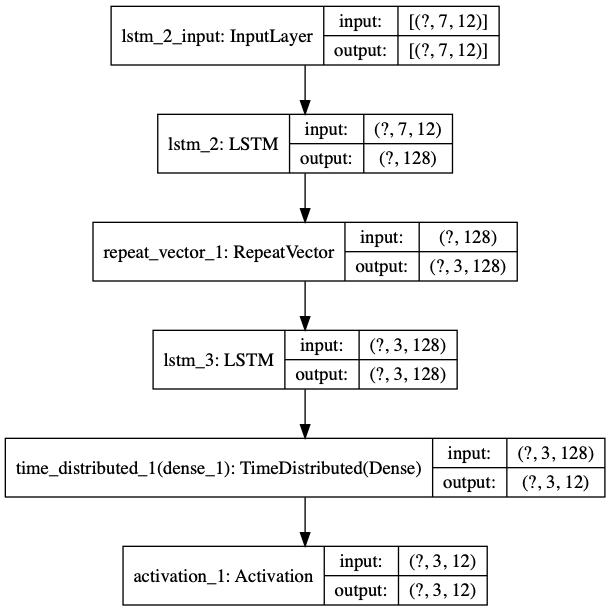

In [38]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Train a model

In [39]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1
)

Train on 4500 samples, validate on 500 samples
Epoch 1/200
4500/4500 [==============================] - 8s 2ms/sample - loss: 2.2930 - accuracy: 0.2479 - val_loss: 2.0533 - val_accuracy: 0.3713
Epoch 2/200
4500/4500 [==============================] - 2s 459us/sample - loss: 1.9033 - accuracy: 0.3799 - val_loss: 1.8624 - val_accuracy: 0.3833
Epoch 3/200
4500/4500 [==============================] - 2s 400us/sample - loss: 1.8004 - accuracy: 0.3862 - val_loss: 1.7372 - val_accuracy: 0.3987
Epoch 4/200
4500/4500 [==============================] - 2s 460us/sample - loss: 1.7379 - accuracy: 0.3869 - val_loss: 1.7099 - val_accuracy: 0.3913
Epoch 5/200
4500/4500 [==============================] - 2s 409us/sample - loss: 1.7058 - accuracy: 0.3988 - val_loss: 1.7287 - val_accuracy: 0.3893
Epoch 6/200
4500/4500 [==============================] - 2s 457us/sample - loss: 1.6845 - accuracy: 0.4030 - val_loss: 1.6997 - val_accuracy: 0.3907
Epoch 7/200
4500/4500 [==============================] - 2s 4

4500/4500 [==============================] - 2s 415us/sample - loss: 0.4492 - accuracy: 0.8778 - val_loss: 0.4445 - val_accuracy: 0.8700
Epoch 56/200
4500/4500 [==============================] - 2s 432us/sample - loss: 0.4139 - accuracy: 0.8975 - val_loss: 0.4307 - val_accuracy: 0.8773
Epoch 57/200
4500/4500 [==============================] - 2s 433us/sample - loss: 0.4047 - accuracy: 0.8987 - val_loss: 0.5020 - val_accuracy: 0.7740
Epoch 58/200
4500/4500 [==============================] - 2s 424us/sample - loss: 0.4006 - accuracy: 0.8915 - val_loss: 0.3928 - val_accuracy: 0.8867
Epoch 59/200
4500/4500 [==============================] - 2s 452us/sample - loss: 0.3558 - accuracy: 0.9213 - val_loss: 0.3860 - val_accuracy: 0.8860
Epoch 60/200
4500/4500 [==============================] - 2s 461us/sample - loss: 0.3537 - accuracy: 0.9148 - val_loss: 0.3938 - val_accuracy: 0.8813
Epoch 61/200
4500/4500 [==============================] - 2s 434us/sample - loss: 0.3238 - accuracy: 0.9331 - val

4500/4500 [==============================] - 2s 466us/sample - loss: 0.0442 - accuracy: 0.9959 - val_loss: 0.0570 - val_accuracy: 0.9893
Epoch 110/200
4500/4500 [==============================] - 2s 473us/sample - loss: 0.0429 - accuracy: 0.9959 - val_loss: 0.0570 - val_accuracy: 0.9913
Epoch 111/200
4500/4500 [==============================] - 2s 419us/sample - loss: 0.0424 - accuracy: 0.9954 - val_loss: 0.0530 - val_accuracy: 0.9913
Epoch 112/200
4500/4500 [==============================] - 2s 426us/sample - loss: 0.0402 - accuracy: 0.9966 - val_loss: 0.0588 - val_accuracy: 0.9893
Epoch 113/200
4500/4500 [==============================] - 2s 435us/sample - loss: 0.0398 - accuracy: 0.9962 - val_loss: 0.0496 - val_accuracy: 0.9907
Epoch 114/200
4500/4500 [==============================] - 2s 449us/sample - loss: 0.0390 - accuracy: 0.9955 - val_loss: 0.0485 - val_accuracy: 0.9913
Epoch 115/200
4500/4500 [==============================] - 2s 437us/sample - loss: 0.0389 - accuracy: 0.9953

4500/4500 [==============================] - 2s 378us/sample - loss: 0.0115 - accuracy: 0.9995 - val_loss: 0.0215 - val_accuracy: 0.9940
Epoch 164/200
4500/4500 [==============================] - 2s 462us/sample - loss: 0.0105 - accuracy: 0.9996 - val_loss: 0.0218 - val_accuracy: 0.9953
Epoch 165/200
4500/4500 [==============================] - 2s 427us/sample - loss: 0.0110 - accuracy: 0.9996 - val_loss: 0.0191 - val_accuracy: 0.9967
Epoch 166/200
4500/4500 [==============================] - 2s 424us/sample - loss: 0.0101 - accuracy: 0.9996 - val_loss: 0.0198 - val_accuracy: 0.9960
Epoch 167/200
4500/4500 [==============================] - 2s 422us/sample - loss: 0.0097 - accuracy: 0.9999 - val_loss: 0.0196 - val_accuracy: 0.9960
Epoch 168/200
4500/4500 [==============================] - 2s 456us/sample - loss: 0.0094 - accuracy: 0.9996 - val_loss: 0.0205 - val_accuracy: 0.9947
Epoch 169/200
4500/4500 [==============================] - 2s 453us/sample - loss: 0.0120 - accuracy: 0.9987

In [42]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

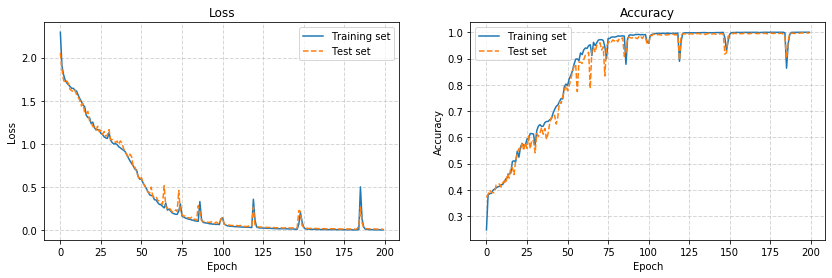

In [43]:
render_training_history(history)

## Test a dataset

In [44]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 1 0 0 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 0 0 0 0 0 0 0 1 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


In [45]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[2.09618154e-08 1.65250447e-06 9.28491312e-12 1.33737617e-12
  8.91551832e-11 5.20520427e-09 7.65816310e-07 8.70008138e-04
  9.96125638e-01 3.00194160e-03 9.83767841e-12 8.05468019e-12]
 [9.94650662e-01 4.23331652e-03 1.51860172e-06 8.91040797e-10
  2.02443021e-10 2.96883720e-12 1.75847878e-11 1.37563019e-08
  6.94156142e-07 1.10599503e-03 1.52009325e-11 7.77936020e-06]
 [9.82914862e-05 2.39291054e-09 4.87958632e-11 4.02099876e-13
  7.78445722e-13 5.69859643e-14 2.99191991e-11 1.10336424e-08
  1.04083364e-08 6.22392179e-07 2.48839556e-12 9.99901056e-01]]

predictions[1]:
 [[9.1141981e-12 9.9998736e-01 2.8987480e-14 1.9401980e-17 1.7401653e-16
  1.4555607e-16 6.7501953e-15 8.9038786e-13 2.5389661e-09 1.2661624e-05
  1.6635848e-15 5.9574064e-17]
 [9.9704957e-01 1.6794143e-03 1.7508242e-08 1.0089089e-10 6.4129785e-11
  3.4519033e-11 1.4319482e-10 2.1030728e-09 7.6049872e-08 1.2708271e-03
  1.6249288e-11 2.3034108e-10]
 [1.0355317e-01 5.

In [46]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

21+59   = 80  [predict: 80 ] ✓
12+97   = 109 [predict: 109] ✓
60+96   = 156 [predict: 156] ✓
42+89   = 131 [predict: 131] ✓
48+32   = 80  [predict: 80 ] ✓
74+73   = 147 [predict: 147] ✓
48+8    = 56  [predict: 56 ] ✓
2+94    = 96  [predict: 96 ] ✓
21+60   = 81  [predict: 81 ] ✓
34+70   = 104 [predict: 104] ✓
64+57   = 121 [predict: 121] ✓
11+39   = 50  [predict: 50 ] ✓
40+44   = 84  [predict: 84 ] ✓
47+80   = 127 [predict: 127] ✓
10+57   = 67  [predict: 67 ] ✓
72+97   = 169 [predict: 169] ✓
54+8    = 62  [predict: 62 ] ✓
89+74   = 163 [predict: 163] ✓
5+64    = 69  [predict: 69 ] ✓
27+58   = 85  [predict: 85 ] ✓
68+57   = 125 [predict: 125] ✓
18+34   = 52  [predict: 52 ] ✓
39+45   = 84  [predict: 84 ] ✓
61+22   = 83  [predict: 83 ] ✓
36+84   = 120 [predict: 120] ✓
66+89   = 155 [predict: 155] ✓
62+34   = 96  [predict: 96 ] ✓
80+3    = 83  [predict: 83 ] ✓
27+92   = 119 [predict: 119] ✓
33+75   = 108 [predict: 108] ✓
14+23   = 37  [predict: 37 ] ✓
17+100  = 117 [predict: 116] 
86+44   =

## Save a model

In [47]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/numbers_summation_rnn/numbers_summation_rnn.h5 \
  ./demos/public/models/numbers_summation_rnn
```

You may find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.